# CalCOFI - Linear Regression Project

**Notice:This project is currently under development and will be improved**

CalCOFI - Linear Regression project explores a series of hydrographic data collected from March 1949 - June 2018 by the California Cooperative Oceanic Fisheries Investigations - CalCOFI[1]. The research is the longest and most complete time series of oceanographic data, providing chemical and biological information about the marine ecosystems off California. The dataset also allows scientists to study El Niño cycles and the effects of climate change.[2][3] 
 
CalCofi data is collected with the sampling method of "bottles-hung-on-wire", that consist of multiple bottles connected to a wire suspended in various depths of the ocean. Bottles are deployed in the ocean and stay for at least 10 minutes until temperature equilibrium is reached. After that the bottles are closed with a weight that can slip through the wire, and the samples for each depth are encapsulated in the bottles for further analysis with a water-tight seal. The method allows collecting chemical and biological data for each depth, which is important since chemical properties changes trough the ocean depth.[4]


##  Main Goal

In this part of the project, I decided to focus on the chemical characteristics of the water reported on the CalCOFI data. My interest were to develop a linear regression model and also a multiple regression model for the data that also had a comprehensive chemical meaning. To allow that exploration I focused on the relationship between depth, temperatures, and salinity, which is well understood in the physical chemistry field and affects water convection currents in the ocean.[5]

Bellow is the project code and at the end of the project, some suggestions for further analysis of the data and the references used for the text are provided. 

### 1. Importing packages


![CalCOFIStationMap, wikipedia](https://en.wikipedia.org/wiki/CalCOFI#/media/File:CalCOFIStationMap.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
sns.set()
%matplotlib inline

### 2. Reading the data 

The data from CalCOFI is separated into two files, bottle, and cast. Bottle data is the data from the bottles used for the sampling method described above. The bottles for different depths are grouped in Casts, and the data from the casts are available in the casts dataset. 

In this part of the project the cast dataset was not explored, but in the end of the document some suggestions of analysis that depend on of both datasets were described. Cast dataset will be especialy important for analysis that involves dates.

Pandas function read_csv were used to read the file.

In [2]:
ocean = pd.read_csv(r"C:\Users\marin\Desktop\Ocean\bottle.csv",sep=",", encoding = 'unicode_escape', usecols=lambda x: x not in ["IncTim","DIC Quality Comment"])


In [3]:
cast = pd.read_csv(r"C:\Users\marin\Desktop\Ocean\cast.csv",sep=",", encoding = 'unicode_escape', usecols=["Cst_Cnt","Date","Year","Month"])


### 2. Choosing variables for the analysis

In this part of the project, the main focus is to analyze some physical-chemical characteristics, so I selected the following variables from the dataset:

Chosen variables:  
*Cst_Cnt* -Auto-numbered Cast Count - all casts consecutively numbered. 1 is first station done  
*Depthm* - Depth in meters  
*T_degC* - Temperature of Water - Degrees C
*Salnty*-  Salinity of water - Practical Salinity Scale, 1978 (UNESCO, 1981a)  
*O2ml_L* - Milliliters of dissolved oxygen per Liter seawater - Oxygen in mL/L  
*STheta* - Potential Density of Water

Although there were other variables related to oxygen in water, O2ml_L were chosen due to higher data availability.

In [4]:
ocean= ocean[["Cst_Cnt","T_degC","Depthm","Salnty","O2ml_L","STheta"]]

### 3. Exploratory Analysis


Before choosing which variables would be chosen for the model some exploratory analysis was necessary, to check the consistency and the characteristics of the data. Bellow is the exploratory analysis process.

#### 3.1 - Info and head

The data has 6 columns and 864863 entries. Looking in ocean.info() results it appears that it will not be necessary to make transformations in the types of the variables since most of them are in float64 or int64 format. The variable O2ml_L has fewer entries than the other variables, so I might not consider it on my model. From the head print is possible to see that for each cast multiple depth samples were collected and that the first samples do not account for the dissolved oxygen data, which explains the lack of data for the variable.

In [5]:
ocean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 6 columns):
Cst_Cnt    864863 non-null int64
T_degC     853900 non-null float64
Depthm     864863 non-null int64
Salnty     817509 non-null float64
O2ml_L     696201 non-null float64
STheta     812174 non-null float64
dtypes: float64(4), int64(2)
memory usage: 39.6 MB


In [6]:
ocean.head(5)


,Cst_Cnt,T_degC,Depthm,Salnty,O2ml_L,STheta
0,1,10.50,0,33.440,NaN,25.649
1,1,10.46,8,33.440,NaN,25.656
2,1,10.46,10,33.437,NaN,25.654
3,1,10.45,19,33.420,NaN,25.643
4,1,10.45,20,33.421,NaN,25.643


#### 3.2 - Descriptive statistics 

With the function describe we can see most of the columns descriptive statistics. T_degC,Salinity and O2ml_L appears to approximate to a normal distribution since the mean is relatively close to the median.

It is possible to notice that depth has large variability, with samples from the surface until 5351m deep. But those large values from depth are probable real variables since the deepest point of the ocean has 10,994 meters of depth according to the United States Center for Coastal & Ocean Mapping [6]. The data collected is almost half of that but shows how impressive is the research done from CalCOFI.

But another variable also draws attention to the maximum values, but unlike depth, those values may not be correct. Stheta the variable of potential density presents the maximum value of 250.784, at the same time, most of its values are distributed between 20.93 to 26.64. The maximum value is almost ten times larger than the mean value, and it's probably a data entry error

In [7]:
ocean.describe()

,Cst_Cnt,T_degC,Depthm,Salnty,O2ml_L,STheta
count,864863.000000,853900.000000,864863.000000,817509.000000,696201.000000,812174.000000
mean,17138.790958,10.799677,226.831951,33.840350,3.392468,25.819394
std,10240.949817,4.243825,316.050259,0.461843,2.073256,1.167787
min,1.000000,1.440000,0.000000,28.431000,-0.010000,20.934000
25%,8269.000000,7.680000,46.000000,33.488000,1.360000,24.965000
50%,16848.000000,10.060000,125.000000,33.863000,3.440000,25.996000
75%,26557.000000,13.880000,300.000000,34.196900,5.500000,26.646000
max,34404.000000,31.140000,5351.000000,37.034000,11.130000,250.784000


To check the  hypothesis that the maximum values of STheta are a result of an entry error a boxplot were created, and I also looked to which depths those values were connected, and it seems like the values were just an entry error in the casts 33911 and 33728 as it was expected.

After filtering the values of STheta to only those bellow 200, the variable also presented statistics that suggest a distribution close to normal.

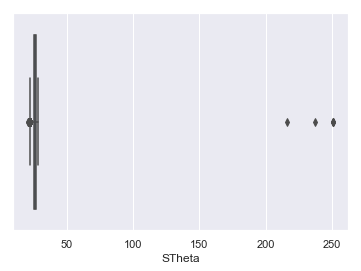

In [8]:
sns.boxplot(ocean.STheta)

In [9]:
df_out=ocean[["Cst_Cnt","Depthm","STheta"]].sort_values(by='STheta',ascending=False)
df_out.head(7)


,Cst_Cnt,Depthm,STheta
852222,33911,10,250.7840
852224,33911,9,250.7840
852223,33911,10,250.7840
852221,33911,9,250.7840
847558,33728,74,237.1793
847549,33728,10,216.5753
809349,32242,900,28.1390


In [10]:
ocean.STheta=ocean.STheta[ocean.STheta<200]
ocean.describe()

,Cst_Cnt,T_degC,Depthm,Salnty,O2ml_L,STheta
count,864863.000000,853900.000000,864863.000000,817509.000000,696201.000000,812168.000000
mean,17138.790958,10.799677,226.831951,33.840350,3.392468,25.817791
std,10240.949817,4.243825,316.050259,0.461843,2.073256,1.007309
min,1.000000,1.440000,0.000000,28.431000,-0.010000,20.934000
25%,8269.000000,7.680000,46.000000,33.488000,1.360000,24.965000
50%,16848.000000,10.060000,125.000000,33.863000,3.440000,25.996000
75%,26557.000000,13.880000,300.000000,34.196900,5.500000,26.646000
max,34404.000000,31.140000,5351.000000,37.034000,11.130000,28.139000


### 4. Visual Exploration - Histograms

The descriptive statistics suggested that most of the variables have a distribution that is probably close to the normal distribution since the mean and the median are relatively close. With the visual exploration, we can check that statement with more detail.

What we see is that the distribution for Salnty, O2ml_L and	STheta is not exactly normal, but more close to a bimodal distribution. Depth, on the other hand, has a skewed distribution to the left as most samples are taken at lower depths, which are probably easier to measure (I can only imagine how hard it is to measure something 5000m deep on the ocean).

#### 4.1 Temperature - Histogram

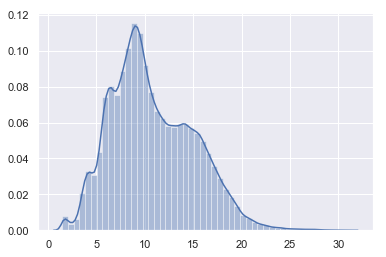

In [11]:
sns.distplot(ocean[["T_degC"]].dropna())


#### 4.2 Depth- Histogram

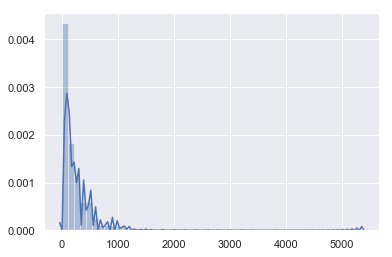

In [12]:
sns.distplot(ocean[["Depthm"]].dropna())


#### 4.3 Salinity - Histogram

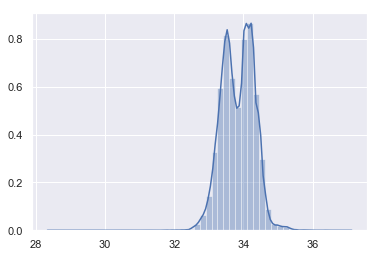

In [13]:
sns.distplot(ocean[["Salnty"]].dropna())


#### 4.4 Milliliters of dissolved oxygen - Histogram

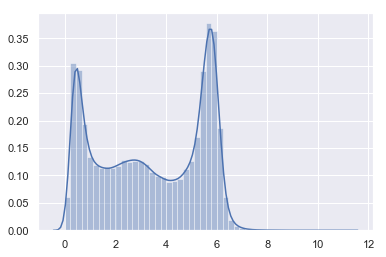

In [14]:
sns.distplot(ocean[["O2ml_L"]].dropna())


#### 4.5 Potential density - Histogram

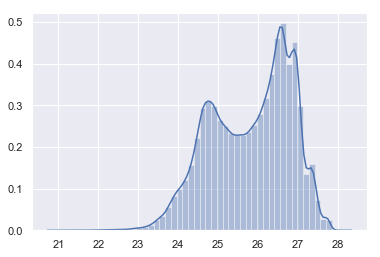

In [15]:
sns.distplot(ocean[["STheta"]].dropna())

### 5. Correlation Analysis

To be able to create a linear regression model is important to check the correlation between the variables. The correlation heatmap is an awesome method to check all the correlations at once. 

Looking at the table the strong correlation between potential density and Temperature was something I decided to explore. That correlation is expected due to the definition of potential density.

Most of the density variation in the water is a result of pressure changes, so the sampling in different depths will affect the density measures since the water sample will be under a larger water column. The potential density is a more useful way to evaluate density in ocean data through multiple depths, it consists on the density a parcel has when moved adiabatically to a reference pressure, and it can be calculated using temperature and salinity. [7]

The idea was to create a linear model, knowing about the existing relationship to predict the value of potential density using the values from salinity and temperature without using any existing equation. 

Potential density has a really strong negative correlation with temperature and a relative correlation with salinity. But if Salinity had a strong correlation with temperature that could create a problem of multicolinearity in my model, but evaluating the correlation of those variables the value seems to be acceptable (-0.51).

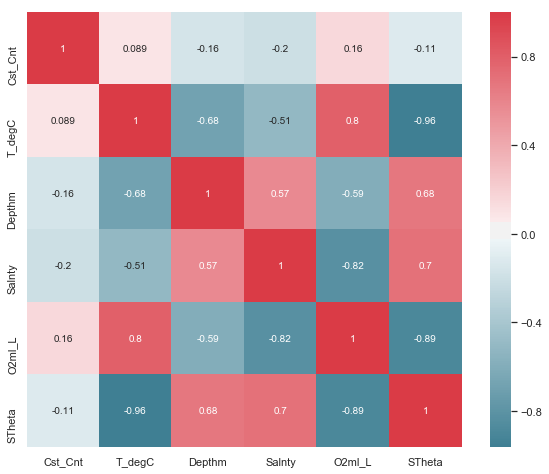

In [16]:
f, ax = plt.subplots(figsize=(10, 8))
corr = ocean.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)
plt.show()

### 5. Visual Analysis - Scatterplot

To allow a better understanding of the data is interesting to look at the scatterplot between or target variable STheta and our variables that will be used to model STheta, Temperature, and salinity. The plots show that Stheta and T_degC are in fact really close to a linear model, so that variable will be considered for the simple linear regression. The Salinity plot, on the other hand, shows a less obvious relation, but it may be useful in the multiple regression model, and since we know salinity is a factor considered on potential density calculations that variable will not be disregarded.

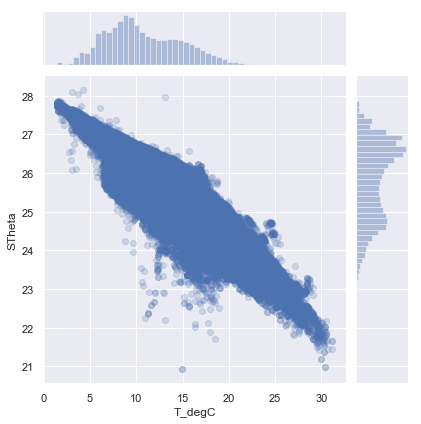

In [17]:
sns.jointplot(y="STheta",x="T_degC",data=ocean,alpha=0.2)
plt.show()

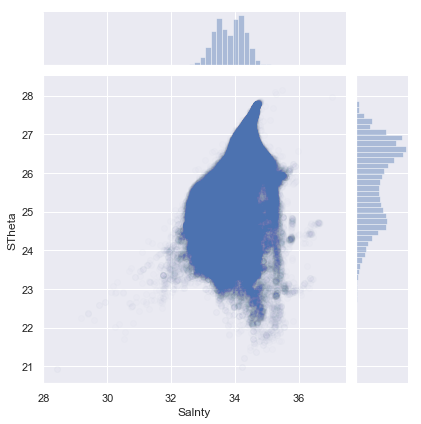

In [18]:
sns.jointplot(y="STheta",x="Salnty",data=ocean,alpha=0.01)
plt.show()
#print(sns.joinplot.__doc__)


#### 6. Adjusting the Simple linear regression -Potential Density x Temperature 

The linear regression model was calculated with statsmodel. The preference for this package is due to the full report it presents, allowing a better evaluation of the quality of the model.

In [19]:
ocean_lm=ocean[["STheta","T_degC"]].dropna()
model_lm=ols(formula="STheta~T_degC",data=ocean_lm).fit()
print(model_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 STheta   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 1.052e+07
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:48:23   Log-Likelihood:                -87963.
No. Observations:              812168   AIC:                         1.759e+05
Df Residuals:                  812166   BIC:                         1.760e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.3121      0.001   3.43e+04      0.0

In [20]:
slm_table = sm.stats.anova_lm(model_lm)
print(slm_table)

                df         sum_sq        mean_sq             F  PR(>F)
T_degC         1.0  765029.265873  765029.265873  1.052149e+07     0.0
Residual  812166.0   59053.506610       0.072711           NaN     NaN


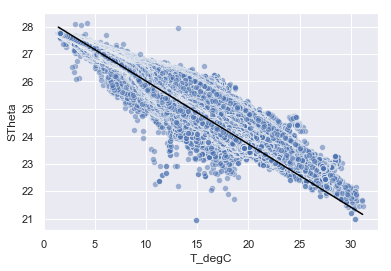

In [21]:
b0 = model_lm.params['Intercept']
b1=model_lm.params['T_degC']

x = np.linspace(np.min(ocean["T_degC"]), np.max(ocean["T_degC"]), 101)
y_model = b1*x + b0

sns.scatterplot(y="STheta",x="T_degC",data=ocean,alpha=0.5)
plt.plot(x,y_model,linestyle='-', color='black')
plt.show()

#### 7. Adjusting the Multiple linear regression - Potential Density x Temperature x Salinity

In [35]:
ocean_mlm=ocean[["STheta","T_degC","Salnty"]].dropna()
model_mlm=ols(formula="STheta~T_degC+Salnty",data=ocean_mlm).fit()
print(model_mlm.summary())

                            OLS Regression Results                            
Dep. Variable:                 STheta   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 4.524e+07
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:58:45   Log-Likelihood:             7.5926e+05
No. Observations:              812168   AIC:                        -1.519e+06
Df Residuals:                  812165   BIC:                        -1.518e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5072      0.009    713.992      0.0

In [23]:
model_mlm = sm.stats.anova_lm(model_mlm)
print(slm_table)

                df         sum_sq        mean_sq             F  PR(>F)
T_degC         1.0  765029.265873  765029.265873  1.052149e+07     0.0
Residual  812166.0   59053.506610       0.072711           NaN     NaN


#### 8. Next goals on the project

a) Finish evaluating and describing in the project the quality of the simple linear model, and the multiple linear model  
b) Evaluate the multiple linear model using train and test from numpy  
c) Create a simple linear model for depth and T_degC adjusting the data from Depth to allow that model (Temp x Depth is not linear but it seems easy to model).  


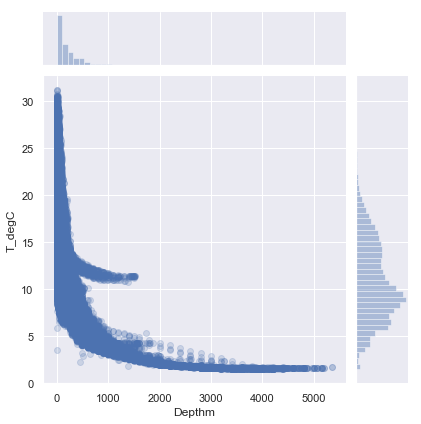

In [24]:
sns.jointplot(y="T_degC",x="Depthm",data=ocean,alpha=0.2)
plt.show()

### 9. Sugestion for following analysis

a) Combine ocean data with cast data to do some time series analysis  
b) Try to identify the main El Nino occurrences in the data  
c) See if the data that presents evidence of the effects of climate change  

### 10. References:

[1] CalCOFI Dataset -https://newdata.calcofi.org/index.php/database/calcofi-database  
[2] CalCOFI - https://en.wikipedia.org/wiki/CalCOFI  
[3] CalCOFI information -https://www.kaggle.com/sohier/calcofi  
[4] Sampling Method -https://www.calcofi.org/about-calcofi/methods/691-calcofi-bottle-sampling.html   
[5] Density/Salinity/Temperature relation - https://manoa.hawaii.edu/exploringourfluidearth/physical/density-effects/density-temperature-and-salinity    
[6]Deepest part of the ocean - https://geology.com/records/deepest-part-of-the-ocean.shtml  
[7] Potential Density - http://pordlabs.ucsd.edu/ltalley/sio210/PPSW/index.html  
